# <font color = 'indianred'>**Identify Duplicate Questions in Quora Question Pairs using BERT** </font>

**Objective:**

The objective of this notebook is to expand upon our previous work with BERT in sentiment analysis, where we successfully harnessed the model's capabilities for sentence-level classification tasks. Building on that foundation, we now aim to explore a more complex application of BERT: sentence pair classification. Specifically, our goal is to develop a solution that can accurately identify duplicate question pairs within the Quora dataset. This notebook will guide us through the entire process, from data understanding and preprocessing to model training and evaluation.

**Key Changes and Innovations from prebious Notebook:**

Most of the functions will be same as previous notebooks. We will need to change the tokenizer function. We will also see that the output of the tokenization function will change.

**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference

-----
**Process**

<img src ="https://drive.google.com/uc?export=view&id=1fuxcrnb4hMlQsYBHhaTsiduV1uBxV58p" width =400>


--------
Model

<img src ="https://drive.google.com/uc?export=view&id=1tPesG4bxm4CMvXs71ZTyp3bgb7LdZzXb" width =600>

------
Embedding layers

<img src ="https://drive.google.com/uc?export=view&id=1tEfy9r5Rjjcz1wCzDovrmqLNgcpjKs4G" width =600>
















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate swifter -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 k

<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard data science librraies for data handling and v isualization
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# New libraries introduced in this notebook
import evaluate
import torch
from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import Pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
from pprint import pprint
import wandb
from google.colab import userdata
from huggingface_hub import login

In [3]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [4]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [5]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


# <font color = 'indianred'> **2. Load Data set**
    


**Quora Dataset**

The Quora dataset is composed of question pairs, and the task is to determine if the questions are paraphrases of each other (have the same meaning).



In [6]:
quora_dataset = load_dataset("quora", trust_remote_code=True)

README.md:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

quora.py:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

In [7]:
# Renaming 'is_duplicate' column to 'labels' to match the naming convention expected by Hugging Face Trainer
quora_dataset = quora_dataset.rename_column('is_duplicate', 'labels')

# Retrieve the features of the 'train' split from the quora_dataset
features = quora_dataset['train'].features

# Define the 'labels' feature as a ClassLabel with two classes: 'not_duplicate' and 'duplicate'
features['labels'] = ClassLabel(num_classes=2, names=['not_duplicate', 'duplicate'])

# Cast the 'labels' column in the dataset to the ClassLabel type, ensuring compatibility with Hugging Face's Trainer
quora_dataset = quora_dataset.cast(features)

Casting the dataset:   0%|          | 0/404290 [00:00<?, ? examples/s]

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>

We only have train split, we will create train/valid/test splits now.

<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [8]:
# Split the test set into test and validation sets
train_temp_splits = quora_dataset["train"].train_test_split(
    test_size=0.7, seed=42)  # 70% for training, 30% for test/validation

val_test_splits = train_temp_splits["test"].train_test_split(
    test_size=0.5, seed=42)  # 15% for validation and 15% for test

# Extract the test and validation splits
train_split = train_temp_splits["train"]
valid_split = val_test_splits["train"]
test_split = val_test_splits["test"]


<font color = 'indianred'> *Create subset for experimentation* </font>

In [9]:
train_split_small = train_split.shuffle(seed=32).select(range(5000))
val_split_small = valid_split.shuffle(seed=32).select(range(500))
test_split_small = test_split.shuffle(seed=32).select(range(500))


<font color = 'indianred'>*Combine splits*</font>

We will combine train and validation splits as we will be applying the same processing steps to both the splits.


In [10]:
train_val_small = DatasetDict(
    {"train": train_split_small, "valid": val_split_small})

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>

In our next step, we will download a pre-trained tokenizer specifically designed to work with BERT. This tokenizer will handle the conversion of our text into a format that BERT can understand.

In [11]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [12]:
def tokenize_fn(batch):
  question1 = []
  question2 = []
  for question_pair in batch['questions']:
    question1.append(question_pair['text'][0])
    question2.append(question_pair['text'][1])

  return tokenizer(text = question1, text_pair = question2, truncation=True)


<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [13]:
tokenized_dataset_small = train_val_small.map(tokenize_fn, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset_small = tokenized_dataset_small.remove_columns(
    ['questions']
)

In [15]:
tokenized_dataset_small.set_format(type='torch')

The varying lengths in the dataset indicate that padding has not been applied yet. Instead of padding the entire dataset, we prefer processing small batches during training. Padding is done selectively for each batch based on the maximum length in the batch. We will discuss this in more detail in a later section of this notebook.

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**



In [16]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)  # We are using the same checkpiont as we have used for tokenizer


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

<font color = 'indianred'>*Download config file of pre-trained Model*</font>



In [17]:
config = AutoConfig.from_pretrained(checkpoint)


<font color = 'indianred'>*Modify Configuration File*</font>


In [18]:
class_names = tokenized_dataset_small["train"].features["labels"].names

In [19]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[id_] = label_

label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_


In [20]:
config.id2label = id2label
config.label2id = label2id


In [21]:
model.config = config

##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [22]:
def compute_metrics(eval_pred):
    combined_metrics = evaluate.combine([evaluate.load("accuracy"),
                                        evaluate.load("f1", average="binary")])

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    evaluations = combined_metrics.compute(
        predictions=predictions, references=labels)
    return evaluations

## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [23]:
# Define the directory where model checkpoints will be saved
run_name = "nlp_fall_2024/quora/bert"
base_folder = Path(basepath)
model_folder = Path("/content/bert_quora")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=64,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=64,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=25,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=25,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='quora_pair_feb_03',  # Experiment name for Weights & Biases

    ## speedups #### NEW ################
    fp16=True
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


- Enabling `fp16=True` in `TrainingArguments` activates mixed-precision training, allowing the model to use 16-bit floating-point precision (as opposed to the default 32-bit). This can lead to faster computation and reduced memory usage on compatible hardware, potentially accelerating the training process without significantly affecting model accuracy.

##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [24]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_small["train"],
    eval_dataset=tokenized_dataset_small["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


<ipython-input-24-0422f66644be>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [25]:
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2024-quora-question-answer

env: WANDB_PROJECT=nlp_course_fall_2024-quora-question-answer


##  <font color = 'indianred'> **6.7 Training and Validation**

In [26]:
trainer.train()  # start training


wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,0.596406,0.654000,0.000000
50,0.616400,0.524789,0.722000,0.550162
75,0.616400,0.508173,0.732000,0.682464


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered i

TrainOutput(global_step=79, training_loss=0.5865412482732459, metrics={'train_runtime': 174.7186, 'train_samples_per_second': 28.617, 'train_steps_per_second': 0.452, 'total_flos': 198706402340160.0, 'train_loss': 0.5865412482732459, 'epoch': 1.0})

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [27]:
eval_results = trainer.evaluate(tokenized_dataset_small["valid"])

In [28]:
eval_results

{'eval_loss': 0.5081727504730225,
 'eval_accuracy': 0.732,
 'eval_f1': 0.6824644549763034,
 'eval_runtime': 0.7692,
 'eval_samples_per_second': 649.989,
 'eval_steps_per_second': 10.4,
 'epoch': 1.0}

In [29]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"], "eval_f1": eval_results["eval_f1"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [30]:
valid_output = trainer.predict(tokenized_dataset_small["valid"])


In [31]:
valid_output._fields


('predictions', 'label_ids', 'metrics')

In [32]:
# check shape of predictions and labels
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)


(500, 2)
(500,)


In [33]:
valid_preds = np.argmax(valid_output.predictions, axis=1)
valid_labels = np.array(valid_output.label_ids)


In [34]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


In [35]:
list(model.config.id2label.values())

['not_duplicate', 'duplicate']

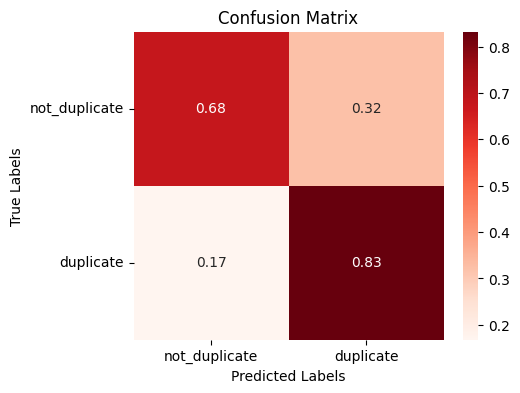

In [36]:
plot_confusion_matrix(valid_labels, valid_preds, class_labels=list(model.config.id2label.values()))

In [37]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=valid_preds, y_true=valid_labels,
    class_names=['neg', 'pos'])})


<font color = 'indianred'> *Get best checkpoint*</font>


In [38]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 75.


#  <font color = 'indianred'> **7. Performance on Test Set**


<font color = 'indianred'>*Load model and tokenizer*</font>

In [39]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/bert_quora/checkpoint-75'

In [40]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config = config )
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model.to('cuda')
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [41]:
test_set_tokenized = test_split_small.map(tokenize_fn, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>



In [42]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[]
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-43-b876edcee308>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<font color = 'indianred'>*Evaluate using Trainer*</font>

In [44]:
test_results = trainer.evaluate()

In [45]:
test_results

{'eval_loss': 0.5035957098007202,
 'eval_model_preparation_time': 0.0033,
 'eval_accuracy': 0.724,
 'eval_f1': 0.6745283018867925,
 'eval_runtime': 5.5259,
 'eval_samples_per_second': 90.483,
 'eval_steps_per_second': 0.724}

In [46]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1": test_results["eval_f1"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [47]:
test_output = trainer.predict(test_set_tokenized)

In [48]:
test_output._fields


('predictions', 'label_ids', 'metrics')

In [49]:
# check shape of predictions and labels
print(test_output.predictions.shape)
print(test_output.label_ids.shape)


(500, 2)
(500,)


In [50]:
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = np.array(test_output.label_ids)


In [51]:
list(model.config.id2label.values())

['not_duplicate', 'duplicate']

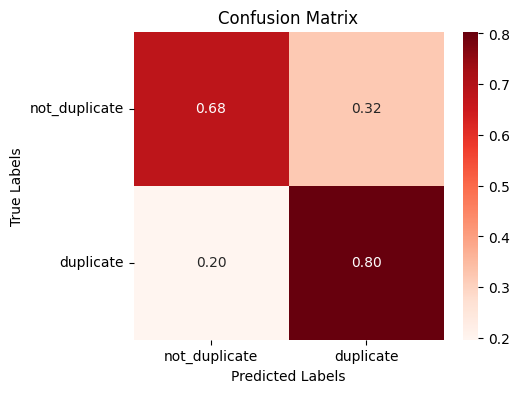

In [52]:
plot_confusion_matrix(test_labels, test_preds, class_labels=list(model.config.id2label.values()))

In [53]:
wandb.finish()

eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▂▁▁
eval/runtime,█▁▁▁
eval/samples_per_second,▁▇██
eval/steps_per_second,▁▇██
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
test/accuracy,▁
test/f1,▁


# <Font color = 'indianred'> **8. Model Inference**
Inference is generally performed on unlabeled datasets, reflecting real-world applications where true labels are unknown. To replicate this, we'll exclude the 'labels' column from our dataset. Moreover, considering the Quora dataset's distinctive arrangement of IDs and question pairs, we'll reformat it to match the typical structure of sentence pair datasets. This standard format usually consists of 'sentence1', 'sentence2', and optionally 'labels' (for labeled datasets), ensuring compatibility with common model expectations and facilitating more seamless data handling and model inference.

In [54]:
test_split_small

Dataset({
    features: ['questions', 'labels'],
    num_rows: 500
})

In [55]:
def transform_example(example):
    return {
        'question1': example['questions']['text'][0],
        'question2': example['questions']['text'][1],

    }

In [56]:
test_split_small_mod = test_split_small.map(transform_example, remove_columns=['questions', 'labels'])


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

- The code defines a function `transform_example` to restructure each example in the `test_split_small` dataset.
- This function extracts `question1`, `question2`from the nested structure within the `questions` key of each example, creating a flattened dictionary with these three keys.
- The `map` method then applies this transformation across the entire `test_split_small` dataset, generating a new dataset `test_split_small_mod` with the restructured format. Additionally, it removes the original `questions` and `labels` columns.

In [57]:
test_split_small_mod.features

{'question1': Value(dtype='string', id=None),
 'question2': Value(dtype='string', id=None)}

<font color = 'indianred'> *Create a custom pipeline* </font>

In the previous notebook, we utilized Hugging Face's `pipeline` for simplicity. However, the `text-classification` pipeline isn't suitable for sentence-pair classification tasks. To address this, we'll build a custom pipeline by subclassing the Hugging Face's `Pipeline` class. This custom pipeline will cater specifically to sentence-pair classification, allowing us to handle pairs of sentences effectively and align with our task requirements.

Creating a custom pipeline by subclassing the Hugging Face's `Pipeline` class involves overriding four key functions to tailor the processing to the specific requirements of sentence-pair classification tasks. Here's an overview of the roles these functions play in the custom pipeline:

1. **`_sanitize_parameters(self, **kwargs)`**:
   - This function preprocesses the pipeline parameters, allowing customization of input arguments before they are processed further. It's particularly useful for handling additional arguments specific to the task or ensuring that inputs meet certain criteria before proceeding.

2. **`preprocess(self, text, second_text=None)`**:
   - The preprocess function is responsible for preparing the input data for the model. In the context of sentence-pair classification, it handles tokenization of both the primary and secondary texts, ensuring that the input is in the correct format (including padding and truncation) that the model expects.

3. **`_forward(self, model_inputs)`**:
   - This function handles the forward pass of the model. It takes the preprocessed inputs and passes them through the model, obtaining the raw outputs. This is where the actual computation by the model occurs.

4. **`postprocess(self, model_outputs)`**:
   - After obtaining the raw outputs from the model, the postprocess function converts these into a more interpretable format. It typically involves extracting the predicted probabilities, determining the best class for each input, and formatting the results into a user-friendly structure.

By overriding these functions, the custom pipeline can be specifically tailored to handle the nuances of sentence-pair classification, providing a streamlined and efficient way to go from raw input text pairs to structured, interpretable predictions.

In [58]:
# inputs = {"a":1, "b":2}
# (**inputs) == (a = 1, b = 2)

In [71]:
class SentencePairClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "second_text" in kwargs:
            preprocess_kwargs["second_text"] = kwargs["second_text"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, second_text=None):
        return self.tokenizer(text, text_pair=second_text, return_tensors=self.framework, padding = True, truncation = True)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        logits = model_outputs.logits
        probabilities = torch.softmax(logits, dim = -1).numpy()

        best_classes = np.argmax(probabilities, axis=1)
        scores = probabilities[np.arange(probabilities.shape[0]), best_classes]
        labels = [self.model.config.id2label[class_idx] for class_idx in best_classes]

        return [
            {"label": label, "score": score.item()}
            for label, score in zip(labels, scores)
        ]


Here's a breakdown of the code:

1. **`_sanitize_parameters` Method:**
  - Validates and formats input parameters, specifically checking for second_text and adjusting preprocess_kwargs accordingly. This step is crucial because, unlike typical single-text pipelines, this pipeline accommodates an additional text input, making it vital to ensure that both texts are correctly processed for the sentence pair classification tasks.

2. **`preprocess` Method:**
   - Prepares the input text for the model.
   - Uses a tokenizer to encode the input `text` and `second_text` (if provided), making sure the inputs are converted into a format the model expects (like converting words into tokens/IDs, padding, and truncation).
   - `return_tensors` specifies the format of the output (PyTorch tensors in this case).

3. **`_forward` Method:**
   - Forwards the preprocessed inputs to the model.
   - Passes the tokenized input through the model, which performs the actual sentence pair classification.

4. **`postprocess` Method:**
   - Processes the outputs of the model to make them interpretable.
   - Converts the model logits to probabilities using softmax.
   - Finds the most probable class for each input pair by selecting the class with the highest probability.
   - Retrieves the corresponding labels for the predicted class indices from the model's configuration.
   - Prepares and returns the final results, including the predicted label, confidence score, and raw logits for each input pair.

Overall, this pipeline provides a structured way to input a pair of sentences into a pre-trained model, perform classification, and return the predictions with corresponding confidence scores and class labels.

In [72]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sentence_pair_pipeline = SentencePairClassificationPipeline(model=model, tokenizer=tokenizer, device = 0, framework='pt')

<font color = 'indianred'> **Test the pipeline on a single input**

In [61]:
# tokenizer??

In [73]:
sample = test_split_small_mod[0]
sample


{'question1': 'What do House Republicans think of President Obama?',
 'question2': 'Do republicans really think President Obama did a bad job?'}

In [74]:
predictions = sentence_pair_pipeline(sample['question1'][0], second_text=sample['question2'][0])
predictions

[{'label': 'not_duplicate', 'score': 0.7244023084640503}]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [75]:
predictions = sentence_pair_pipeline([test_split_small_mod['question1']], second_text=test_split_small_mod['question2'], baTCH_SIZE = 64)


In [76]:
predictions[0][0:3]


[{'label': 'duplicate', 'score': 0.6446027755737305},
 {'label': 'not_duplicate', 'score': 0.8117206692695618},
 {'label': 'not_duplicate', 'score': 0.8967052698135376}]